# Converting_Shapefiles_Into_A_Binary_Raster Notebook

This notebook helps us in achieving the followings:

* It generates the tif files by rasterising the manually annotated shapefiles.
* It will first considers the non-water bodies annotations and generates the tif files by having the difference from its corresponding water bodies annotations.
* It will then considers the remaining ones, the left water bodies annotation which do not contain any not water bodies within the shapefiles.

In [6]:
# Use conda_python3 environment in EC2 Deep Learning AMI (Ubuntu 18.04) Version 27.0

# add helper function location
import sys 
sys.path.append('../functions')

# import helper functions 
from helpers import *

#load packages
import boto3
import os

In [7]:
import os
import glob
import ntpath
from pathlib import Path
from pprint import pprint


import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize

import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [8]:
print(os.getcwd())


/home/ubuntu/rimbun.io/04_Create_training_data


#  Generate the binary mask

## Deal With Annotations Having Both Water And Non Water 

In [9]:
#Function that generates the mask
def poly_from_utm(polygon, transform):
    poly_pts = []

    poly = cascaded_union(polygon)
    for i in np.array(poly.exterior.coords):

        poly_pts.append(~transform * tuple(i))

    new_poly = Polygon(poly_pts)
    return new_poly

def generate_mask(raster_path, water_shape_path, non_water_shape_path, output_path, file_name):
    
    """Function that generates a binary mask from a vector file (shp or geojson)
    
    raster_path = path to the .tif;

    shape_path = path to the shapefile or GeoJson.

    output_path = Path to save the binary mask.

    file_name = Name of the file.
    
    """
    
    #load raster
    
    with rasterio.open(raster_path, "r") as src:
        raster_img = src.read()
        raster_meta = src.meta
    
    #load shapefile or GeoJson
    train_water_df = gpd.read_file(water_shape_pathworldview)
    train_non_water_df = gpd.read_file(non_water_shape_path)
    
    print(" Raster crs : {}, Vector crs : {}.\n Convert vector and raster to the same CRS.".format(src.crs,train_water_df.crs))
    print(" Raster crs : {}, Vector crs : {}.\n Convert vector and raster to the same CRS.".format(src.crs,train_non_water_df.crs))
    
    #Verify crs
    if train_water_df.crs != 4326:
        train_water_df = train_water_df.to_crs({'init' :'epsg:4326'})
        
    if train_non_water_df.crs != 4326:
        train_non_water_df = train_non_water_df.to_crs({'init' :'epsg:4326'})

    
    poly_shp = []
    im_size = (src.meta['height'], src.meta['width'])
    for num, row in train_water_df.iterrows():
        if row['geometry'] is not None and row['geometry'].geom_type == 'Polygon':
            poly = poly_from_utm(row['geometry'], src.meta['transform'])
            poly_shp.append(poly)
        else:
            if row['geometry'] is not None:
                for p in row['geometry']:
                    poly = poly_from_utm(p, src.meta['transform'])
                    poly_shp.append(poly)
                    
    mask1 = rasterize(shapes=poly_shp,
                     out_shape=im_size)
    mask1 = mask1.astype("float32")
    
    poly_shp = []
    im_size = (src.meta['height'], src.meta['width'])
    for num, row in train_non_water_df.iterrows():
        if row['geometry'] is not None and row['geometry'].geom_type == 'Polygon':
            poly = poly_from_utm(row['geometry'], src.meta['transform'])
            poly_shp.append(poly)
        else:
            if row['geometry'] is not None:
                for p in row['geometry']:
                    poly = poly_from_utm(p, src.meta['transform'])
                    poly_shp.append(poly)

    mask2 = rasterize(shapes=poly_shp,
                     out_shape=im_size)
    mask2 = mask2.astype("float32")
    
    #Save
    mask = mask1 - mask2
    
    #Plot
    plt.figure(figsize=(15,15))
    plt.imshow(mask)
    plt.show()
    
    bin_mask_meta = src.meta.copy()
    bin_mask_meta.update({'count': 1})
    output_file_path = os.path.join(output_path, file_name)
    with rasterio.open(output_file_path, 'w', **bin_mask_meta) as dst:
        dst.write(mask * 255, 1)



In [12]:
non_water_shape_files

[]

In [17]:
glob.glob(non_water_shape_path)

[]

In [ ]:
raster_files_root_path= '../data/source_data/'
water_shape_root_path = '../data/hand_annotations/water_annotations/'
non_water_shape_path = '../data/hand_annotations/islands_annotations/*.shp'
mask_files_root_path = '../data/mask_files/'

make_dir(mask_files_root_path)

non_water_shape_files = glob.glob(non_water_shape_path)

# pprint(non_water_shape_files)
for non_water_shape_file_path in non_water_shape_files:
    filename = ntpath.basename(non_water_shape_file_path)
#     filename = filename.replace('_island','')
#     filename = filename.replace(' ', '')
    raster_file_path = os.path.join(raster_files_root_path, filename.replace('shp','tif'))
    water_shape_file_path = os.path.join(water_shape_root_path, filename)
    mask_file_path = os.path.join(mask_files_root_path, filename.replace('shp','tif'))
    output_path = str(Path(mask_file_path).parent)
    pprint(filename)

    

    try:
        print(raster_file_path, water_shape_file_path, mask_file_path)
        generate_mask(raster_file_path, water_shape_file_path, non_water_shape_file_path, output_path, filename.replace('shp','tif'))
    except Exception as e:
        print(e)
        print('still to upload:', filename)

## Deal With The Remaing Annotation Which Only Contains Water

In [19]:
def generate_mask(raster_path, shape_path, output_path, file_name):
    
    """Function that generates a binary mask from a vector file (shp or geojson)
    
    raster_path = path to the .tif;

    shape_path = path to the shapefile or GeoJson.

    output_path = Path to save the binary mask.

    file_name = Name of the file.
    
    """
    
    #load raster
    print(raster_path)
    print(shape_path)
    print(output_path)
    print(file_name)
    with rasterio.open(raster_path, "r") as src:
        raster_img = src.read()
        raster_meta = src.meta
    
    #load o shapefile ou GeoJson
    train_df = gpd.read_file(shape_path)
    
    if not train_df.empty:
        print(train_df)
        #Verify crs
        if train_df.crs != 4326:
            train_df = train_df.to_crs({'init' :'epsg:4326'})


        #Function that generates the mask
        def poly_from_utm(polygon, transform):
            poly_pts = []

            poly = cascaded_union(polygon)
            for i in np.array(poly.exterior.coords):

                poly_pts.append(~transform * tuple(i))

            new_poly = Polygon(poly_pts)
            return new_poly


        poly_shp = []
        im_size = (src.meta['height'], src.meta['width'])
        for num, row in train_df.iterrows():
            if row['geometry'] is not None and row['geometry'].geom_type == 'Polygon':
                poly = poly_from_utm(row['geometry'], src.meta['transform'])
                poly_shp.append(poly)
            else:
                if row['geometry'] is not None:
                    for p in row['geometry']:
                        poly = poly_from_utm(p, src.meta['transform'])
                        poly_shp.append(poly)
        mask = rasterize(shapes=poly_shp,
                         out_shape=im_size)

        #Plot
        plt.figure(figsize=(15,15))
        plt.imshow(mask)
        plt.show()

        #Save
        mask = mask.astype("float32")

        bin_mask_meta = src.meta.copy()geojsongeojson
        bin_mask_meta.update({'count': 1})
        output_file_path = os.path.join(output_path, file_name)
        with rasterio.open(output_file_path, 'w', **bin_mask_meta) as dst:
            dst.write(mask * 255, 1)



In [ ]:
water_shape_root_path = '../data/hand_annotations/water_annotations/*.shp'


non_water_shape_files = glob.glob(non_water_shape_path)
non_water_shape_files = list(map(ntpath.basename,non_water_shape_files))

water_shape_files = glob.glob(water_shape_root_path)


for shape_file_path in water_shape_files:
    filename = ntpath.basename(shape_file_path)
    filename = filename.replace('_island','')
    if filename not in non_water_shape_files:
        
        raster_file_path = os.path.join(raster_files_root_path, filename.replace('shp','tif'))
        mask_file_path = os.path.join(mask_files_root_path, filename.replace('shp','tif'))

        output_path = Path(mask_file_path)
        try:
            generate_mask(raster_path=raster_file_path, shape_path=shape_file_path, output_path=mask_files_root_path, file_name=filename.replace('shp','tif'))
        except Exception as e:
            print(e)
            # print('still to upload:', filename)
            
        #print(filename)

# Visualise the Mask Files

../data/mask_files/Denpasar_003_pansharpen_True_2019-08-12_02:39_1030010097468D00_05-18-2020_08:55:26.tif
../data/mask_files/Denpasar_039_pansharpen_True_2019-08-01_02:45_1030010096902A00_05-18-2020_08:55:26.tif
../data/mask_files/Jakarta_122_pansharpen_True_2019-08-11_03:17_103001009861DE00_05-18-2020_08:55:26.tif


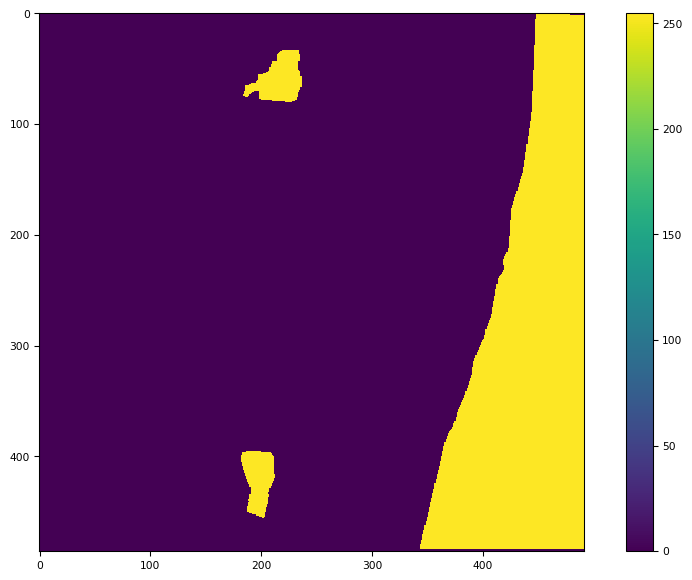

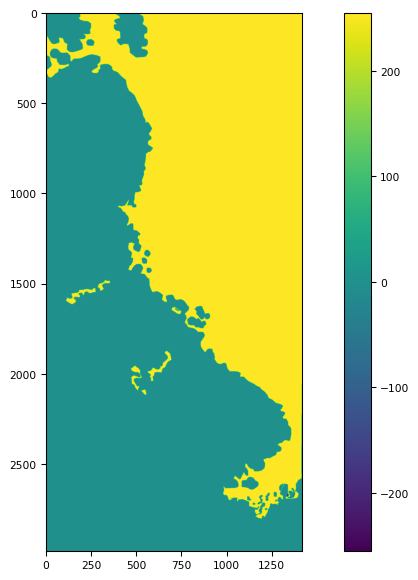

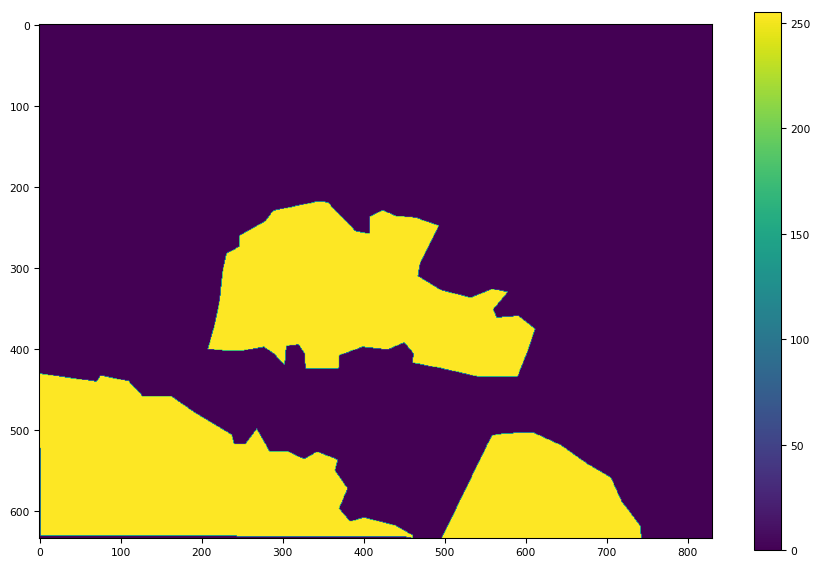

In [23]:
import tifffile as tiff
for mask in glob.glob('../data/mask_files/*.tif')[0:3]:
    img = tiff.imread(mask)
    tiff.imshow(img)
    print(mask)